<a href="https://colab.research.google.com/github/gadenahi/neural_network_sms_text_classifier/blob/master/sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.0-dev20200902


In [2]:
# get data files
TRAIN_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/train-data.tsv"
TEST_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/valid-data.tsv"

train_file_path = tf.keras.utils.get_file("train-data.tsv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("valid-data.tsv", TEST_DATA_URL)

In [3]:
# To read tcv 
df_train = pd.read_table(train_file_path, header=0, names=['indicates', 'text'], usecols=['indicates', 'text'])
df_test = pd.read_table(test_file_path, header=0, names=['indicates', 'text'], usecols=['indicates', 'text'])
# To replace text to numbers. "ham" => 0 and "spam" => "1"
df_train['indicates'] = df_train['indicates'].replace("ham", 0)
df_train['indicates'] = df_train['indicates'].replace("spam", 1)
df_test['indicates'] = df_test['indicates'].replace("ham", 0)
df_test['indicates'] = df_test['indicates'].replace("spam", 1)
# To change to tensorflow dataset
train_data = tf.data.Dataset.from_tensor_slices((df_train['text'].values, df_train['indicates'].values))
test_data = tf.data.Dataset.from_tensor_slices((df_test['text'].values, df_test['indicates'].values))

In [4]:
# to encode from text to numbers

tokenizer = tfds.features.text.Tokenizer()

# To create vocabulary list from all data
vocabulary_set = set()

for text_tensor, _ in train_data.concatenate(test_data):
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

8740

In [5]:
# To create encoder by passing the vocabulary_set
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [6]:
# Now run the encoder on the dataset by wrapping it in tf.py_function and passing that to the dataset's map method.
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

In [7]:
#  to wrap it in a tf.py_function. The tf.py_function will pass regular tensors (with a value and a .numpy() method to access it), to the wrapped python function.
def encode_map_fn(text, label):
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))

  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label

In [8]:
# Run encode the text
train_data_encoded = train_data.map(encode_map_fn)
test_data_encoded = test_data.map(encode_map_fn)

In [9]:
# Prepare data for training
BUFFER_SIZE = 1000
BATCH_SIZE = 32
train_dataset = (train_data_encoded.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE))
test_dataset = (test_data_encoded.padded_batch(BATCH_SIZE))

In [10]:
# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
# Complle the Keras model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
# train the model
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
131/131 [==============================] - 9s 45ms/step - loss: 0.4278 - accuracy: 0.8806 - val_loss: 0.0784 - val_accuracy: 0.9792
Epoch 2/10
131/131 [==============================] - 6s 43ms/step - loss: 0.0402 - accuracy: 0.9892 - val_loss: 0.0395 - val_accuracy: 0.9885
Epoch 3/10
131/131 [==============================] - 6s 41ms/step - loss: 0.0134 - accuracy: 0.9964 - val_loss: 0.0527 - val_accuracy: 0.9885
Epoch 4/10
131/131 [==============================] - 6s 41ms/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 0.0495 - val_accuracy: 0.9896
Epoch 5/10
131/131 [==============================] - 6s 41ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0864 - val_accuracy: 0.9792
Epoch 6/10
131/131 [==============================] - 6s 43ms/step - loss: 0.0044 - accuracy: 0.9979 - val_loss: 0.0501 - val_accuracy: 0.9885
Epoch 7/10
131/131 [==============================] - 6s 41ms/step - loss: 4.7088e-04 - accuracy: 0.9999 - val_loss: 0.0467 - val_accuracy: 0.

In [13]:
# evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

44/44 [==============================] - 1s 16ms/step - loss: 0.0606 - accuracy: 0.9885
Test Loss: 0.060566794127225876
Test Accuracy: 0.9884974956512451


In [14]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  pred_text = encoder.encode(pred_text)
  pred_text = tf.cast(pred_text, tf.float32)
  prediction = model.predict(tf.expand_dims(pred_text, 0)).tolist()
  if prediction[0][0] < 0.5:
    prediction.append('ham')
  else:
    prediction.append('spam')
  return (prediction)

In [15]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

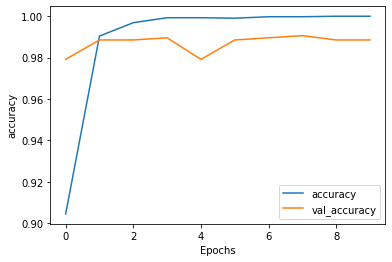

In [16]:
plot_graphs(history, 'accuracy')

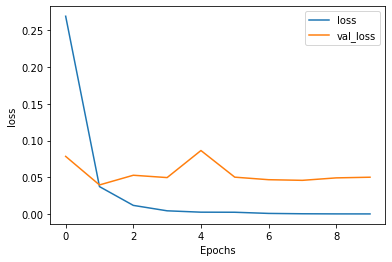

In [17]:
plot_graphs(history, 'loss')

In [18]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    print("hello", prediction, ans)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


hello [[-2.2561895847320557], 'ham'] ham
hello [[5.638829708099365], 'spam'] spam
hello [[-10.216706275939941], 'ham'] ham
hello [[7.760349750518799], 'spam'] spam
hello [[9.041117668151855], 'spam'] spam
hello [[-9.046822547912598], 'ham'] ham
hello [[-7.01843786239624], 'ham'] ham
You passed the challenge. Great job!
